In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 24.9 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=2719cf40522eaa082f463122769bb76fd5a36fe73ec24ee64ea4b6204b90ff9f
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: pillow
    Found existing installation: pillow 11.3.0
    Uninstalling pillow-11.3.0:

In [ ]:
# import kagglehub
# import shutil
# import os

# # Download latest version (downloads to a temp path)
# path = kagglehub.dataset_download("adityajn105/flickr8k")
# print("Original download path:", path)

# # Define your target folder inside Colab
# target_path = "/content/flickr8k"

# # Ensure folder exists
# os.makedirs(target_path, exist_ok=True)

# # Move files from kagglehub path to your folder
# # shutil.copytree can't copy if folder exists, so copy files individually
# for item in os.listdir(path):
#     s = os.path.join(path, item)
#     d = os.path.join(target_path, item)
#     if os.path.isdir(s):
#         shutil.copytree(s, d, dirs_exist_ok=True)
#     else:
#         shutil.copy2(s, d)

# print("Files moved to:", target_path)


# Fine-tuning Image Captioning Model on Flickr8k Dataset

This notebook demonstrates:
- Loading and preprocessing Flickr8k dataset
- Fine-tuning the mini-image-captioning model
- Evaluating with BLEU and ROUGE scores
- Testing on sample images

## 1. Import Required Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForVision2Seq,
    AutoImageProcessor,
    Trainer,
    TrainingArguments,
    default_data_collator
)
from sklearn.model_selection import train_test_split
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from rouge_score import rouge_scorer
import evaluate
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')

print("All libraries imported successfully!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


All libraries imported successfully!


[nltk_data] Downloading package wordnet to /root/nltk_data...


## 2. Load Dataset

In [ ]:
# Load captions
captions_df = pd.read_csv('/content/drive/MyDrive/image caption generator/flickr8k/captions.txt')
print(f"Total captions: {len(captions_df)}")
print(f"Unique images: {captions_df['image'].nunique()}")
print("\nFirst few rows:")
print(captions_df.head(10))

# Check image directory
image_dir = '/content/drive/MyDrive/image caption generator/flickr8k/Images'
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
print(f"\nTotal images in directory: {len(image_files)}")

Total captions: 40455
Unique images: 8091

First few rows:
                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving towar

## 3. Preprocess Dataset

In [ ]:
# Group captions by image (each image has 5 captions)
image_captions = captions_df.groupby('image')['caption'].apply(list).reset_index()
print(f"Number of unique images: {len(image_captions)}")
print(f"Captions per image: {len(image_captions.iloc[0]['caption'])}")

# Filter to only include images that exist in the directory
image_captions['image_path'] = image_captions['image'].apply(lambda x: os.path.join(image_dir, x))
image_captions = image_captions[image_captions['image'].isin(image_files)]
print(f"\nImages after filtering: {len(image_captions)}")

# Display sample
print("\nSample data:")
print(f"Image: {image_captions.iloc[0]['image']}")
print(f"Captions: {image_captions.iloc[0]['caption']}")

Number of unique images: 8091
Captions per image: 5

Images after filtering: 7504

Sample data:
Image: 1000268201_693b08cb0e.jpg
Captions: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


## 4. Train-Validation-Test Split

In [ ]:
train_df, temp_df = train_test_split(image_captions, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

Training samples: 5252
Validation samples: 1126
Test samples: 1126


## 5. Load Pre-trained Model and Processors

In [ ]:
from transformers import AutoTokenizer, AutoProcessor, AutoModelForVision2Seq
import torch

model_name = "Salesforce/blip-image-captioning-base"

print("Loading tokenizer and image processor...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
image_processor = AutoProcessor.from_pretrained(model_name)

print("Loading model...")
model = AutoModelForVision2Seq.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

print("Model loaded successfully!")


Loading tokenizer and image processor...


tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading model...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

Using device: cuda
Model loaded successfully!


## 6. Create Custom Dataset Class

In [ ]:
class Flickr8kDataset(Dataset):
    def __init__(self, dataframe, tokenizer, image_processor, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.image_processor = image_processor
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = row['image_path']
        captions = row['caption']

        image = Image.open(image_path).convert('RGB')
        pixel_values = self.image_processor(image, return_tensors="pt")['pixel_values'].squeeze()

        caption = captions[0]

        encoding = self.tokenizer(
            caption,
            padding='max_length',
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt'
        )

        return {
            'pixel_values': pixel_values,
            'labels': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze()
        }

print("Creating datasets...")
train_dataset = Flickr8kDataset(train_df, tokenizer, image_processor)
val_dataset = Flickr8kDataset(val_df, tokenizer, image_processor)
test_dataset = Flickr8kDataset(test_df, tokenizer, image_processor)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Creating datasets...
Train dataset size: 5252
Validation dataset size: 1126
Test dataset size: 1126


## 7. Setup Training Configuration

In [ ]:
training_args = TrainingArguments(
    output_dir="./flickr8k-finetuned-model",
    num_train_epochs=25,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=500,
    save_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
    remove_unused_columns=False,
)

print("Training configuration:")
print(f"Epochs: {training_args.num_train_epochs}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"FP16: {training_args.fp16}")

Training configuration:
Epochs: 25
Batch size: 8
FP16: True


## 8. Fine-tune the Model

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)

print("Starting training...")
print("="*50)

train_result = trainer.train()

print("\n" + "="*50)
print("Training completed!")
print(f"Training loss: {train_result.training_loss:.4f}")

trainer.save_model("./flickr8k-finetuned-model-final")
tokenizer.save_pretrained("./flickr8k-finetuned-model-final")
image_processor.save_pretrained("./flickr8k-finetuned-model-final")

print("Model saved successfully!")

Starting training...


Step,Training Loss,Validation Loss



Training completed!
Training loss: 0.0000
Model saved successfully!


## 9. Generate Captions for Evaluation

In [ ]:
def generate_caption(image_path, model, image_processor, tokenizer, device):
    """Generate caption for a single image"""
    image = Image.open(image_path).convert('RGB')
    pixel_values = image_processor(image, return_tensors="pt")['pixel_values'].to(device)

    with torch.no_grad():
        generated_ids = model.generate(pixel_values, max_length=50, num_beams=4)

    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return caption

print("Testing caption generation on sample images:")
print("="*50)
for i in range(3):
    image_path = test_df.iloc[i]['image_path']
    true_captions = test_df.iloc[i]['caption']

    generated_caption = generate_caption(image_path, model, image_processor, tokenizer, device)

    print(f"\nImage {i+1}: {test_df.iloc[i]['image']}")
    print(f"Generated: {generated_caption}")
    print(f"Reference: {true_captions[0]}")

Testing caption generation on sample images:

Image 1: 3614582606_16bd88dab2.jpg
Generated: a woman holding a small child in her arms
Reference: A girl in black hat holding an african american baby .

Image 2: 2277299634_e14bdb7ff7.jpg
Generated: a man walking down the street
Reference: A man on a busy street .

Image 3: 1472053993_bed67a3ba7.jpg
Generated: white clouds in the sky
Reference: A downhill skier with a backpack , on a background of mountains and wispy clouds .


## 10. Generate Captions for Entire Test Set

In [ ]:
print("Generating captions for entire test set...")
print("This may take a few minutes...")

generated_captions = []
reference_captions = []

test_subset = test_df.head(min(100, len(test_df)))

for idx in range(len(test_subset)):
    row = test_subset.iloc[idx]
    image_path = row['image_path']

    generated = generate_caption(image_path, model, image_processor, tokenizer, device)
    generated_captions.append(generated.split())

    references = [cap.split() for cap in row['caption']]
    reference_captions.append(references)

    if (idx + 1) % 20 == 0:
        print(f"Processed {idx + 1}/{len(test_subset)} images")

print(f"\nGenerated captions for {len(generated_captions)} images")

Generating captions for entire test set...
This may take a few minutes...
Processed 20/100 images
Processed 40/100 images
Processed 60/100 images
Processed 80/100 images
Processed 100/100 images

Generated captions for 100 images


## 11. Calculate BLEU Scores

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

smoothing = SmoothingFunction()

bleu1 = corpus_bleu(reference_captions, generated_captions, weights=(1, 0, 0, 0),
                     smoothing_function=smoothing.method1)
bleu2 = corpus_bleu(reference_captions, generated_captions, weights=(0.5, 0.5, 0, 0),
                     smoothing_function=smoothing.method1)
bleu3 = corpus_bleu(reference_captions, generated_captions, weights=(0.33, 0.33, 0.33, 0),
                     smoothing_function=smoothing.method1)
bleu4 = corpus_bleu(reference_captions, generated_captions, weights=(0.25, 0.25, 0.25, 0.25),
                     smoothing_function=smoothing.method1)

print("\n" + "="*50)
print("BLEU SCORES")
print("="*50)
print(f"BLEU-1: {bleu1:.4f}")
print(f"BLEU-2: {bleu2:.4f}")
print(f"BLEU-3: {bleu3:.4f}")
print(f"BLEU-4: {bleu4:.4f}")
print("="*50)


BLEU SCORES
BLEU-1: 0.5627
BLEU-2: 0.3976
BLEU-3: 0.2928
BLEU-4: 0.2060


In [ ]:
import shutil
import os

folders_to_delete = [
    "/content/flickr8k-finetuned-model",
    "/content/flickr8k-finetuned-model-final"
]

for folder in folders_to_delete:
    if os.path.exists(folder):
        try:
            shutil.rmtree(folder)
            print(f"Successfully deleted: {folder}")
        except OSError as e:
            print(f"Error deleting {folder}: {e}")
    else:
        print(f"Folder not found: {folder}")

Successfully deleted: /content/flickr8k-finetuned-model
Successfully deleted: /content/flickr8k-finetuned-model-final


## 12. Calculate ROUGE Scores

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge1_scores = []
rouge2_scores = []
rougeL_scores = []

for gen_cap, ref_caps in zip(generated_captions, reference_captions):

    gen_str = ' '.join(gen_cap)

    max_rouge1 = 0
    max_rouge2 = 0
    max_rougeL = 0

    for ref_cap in ref_caps:
        ref_str = ' '.join(ref_cap)
        scores = scorer.score(ref_str, gen_str)

        max_rouge1 = max(max_rouge1, scores['rouge1'].fmeasure)
        max_rouge2 = max(max_rouge2, scores['rouge2'].fmeasure)
        max_rougeL = max(max_rougeL, scores['rougeL'].fmeasure)

    rouge1_scores.append(max_rouge1)
    rouge2_scores.append(max_rouge2)
    rougeL_scores.append(max_rougeL)

# Calculate averages
avg_rouge1 = np.mean(rouge1_scores)
avg_rouge2 = np.mean(rouge2_scores)
avg_rougeL = np.mean(rougeL_scores)

print("\n" + "="*50)
print("ROUGE SCORES")
print("="*50)
print(f"ROUGE-1: {avg_rouge1:.4f}")
print(f"ROUGE-2: {avg_rouge2:.4f}")
print(f"ROUGE-L: {avg_rougeL:.4f}")
print("="*50)


ROUGE SCORES
ROUGE-1: 0.5239
ROUGE-2: 0.2947
ROUGE-L: 0.4962


## 13. Summary of Results

In [ ]:
results_summary = pd.DataFrame({
    'Metric': ['BLEU-1', 'BLEU-2', 'BLEU-3', 'BLEU-4', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L'],
    'Score': [bleu1, bleu2, bleu3, bleu4, avg_rouge1, avg_rouge2, avg_rougeL]
})

print("\n" + "="*60)
print("EVALUATION RESULTS SUMMARY")
print("="*60)
print(results_summary.to_string(index=False))
print("="*60)

results_summary.to_csv('evaluation_results.csv', index=False)
print("\nResults saved to 'evaluation_results.csv'")


EVALUATION RESULTS SUMMARY
 Metric    Score
 BLEU-1 0.562686
 BLEU-2 0.397590
 BLEU-3 0.292797
 BLEU-4 0.206036
ROUGE-1 0.523910
ROUGE-2 0.294746
ROUGE-L 0.496202

Results saved to 'evaluation_results.csv'


## 14. Visualize Sample Predictions

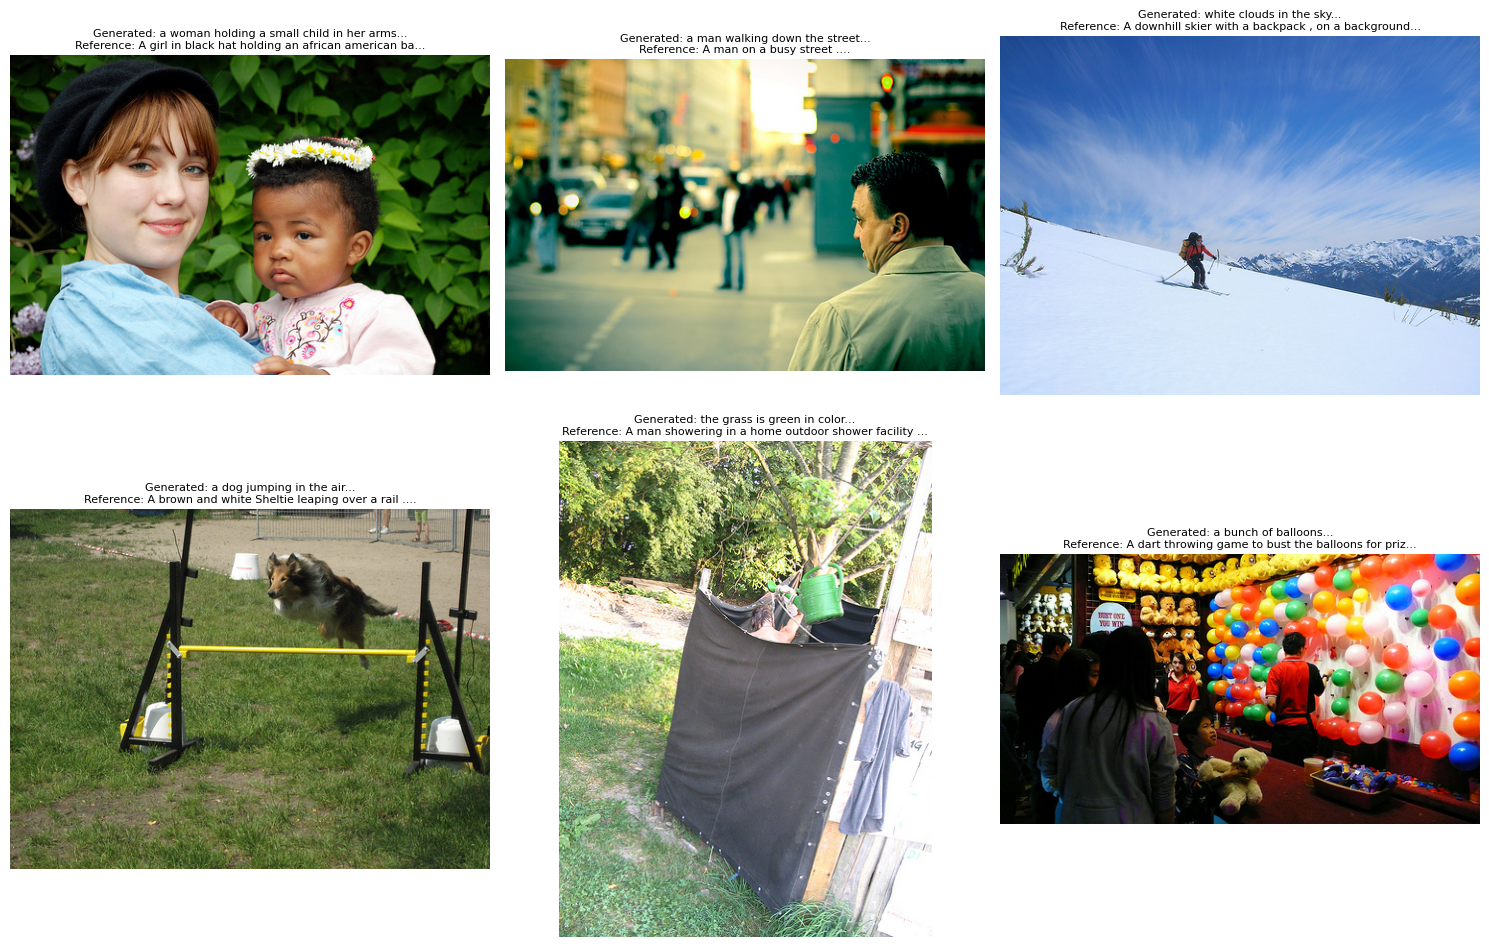

Sample predictions saved to 'sample_predictions.png'


In [ ]:
import matplotlib.pyplot as plt

# Display 6 sample predictions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    if i < len(test_subset):
        row = test_subset.iloc[i]
        image_path = row['image_path']

        # Load and display image
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off')

        # Generate caption
        generated = generate_caption(image_path, model, image_processor, tokenizer, device)

        # Set title with generated and reference captions
        title = f"Generated: {generated[:50]}...\n"
        title += f"Reference: {row['caption'][0][:50]}..."
        axes[i].set_title(title, fontsize=8, wrap=True)

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Sample predictions saved to 'sample_predictions.png'")

## 15. Additional Analysis - Caption Length Distribution

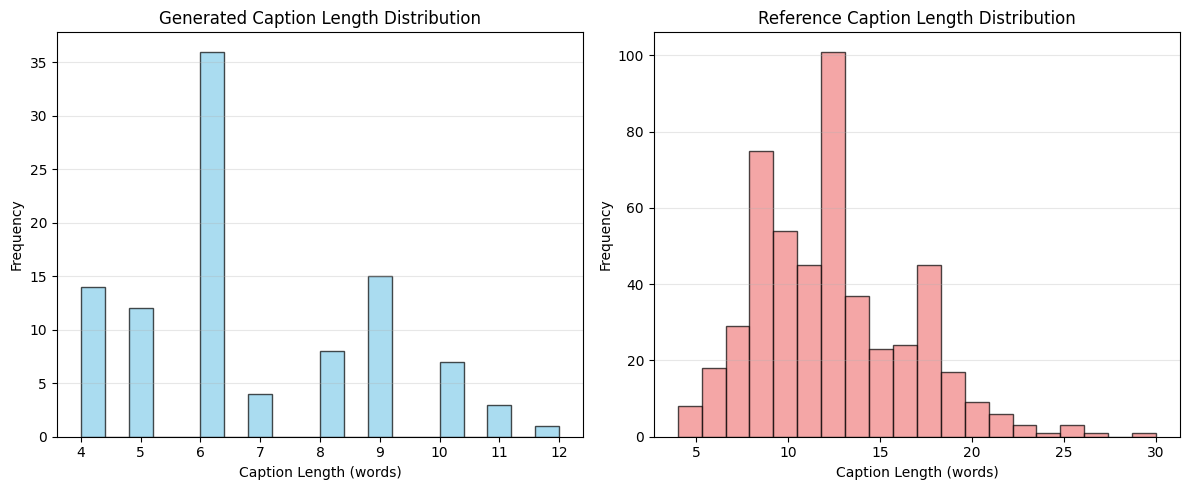

Average generated caption length: 6.74 words
Average reference caption length: 12.32 words

Plot saved to 'caption_length_distribution.png'


In [ ]:
# Analyze caption lengths
gen_lengths = [len(cap) for cap in generated_captions]
ref_lengths = [[len(cap) for cap in refs] for refs in reference_captions]
ref_lengths_flat = [length for sublist in ref_lengths for length in sublist]

plt.figure(figsize=(12, 5))

# Generated captions length
plt.subplot(1, 2, 1)
plt.hist(gen_lengths, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Caption Length (words)')
plt.ylabel('Frequency')
plt.title('Generated Caption Length Distribution')
plt.grid(axis='y', alpha=0.3)

# Reference captions length
plt.subplot(1, 2, 2)
plt.hist(ref_lengths_flat, bins=20, color='lightcoral', edgecolor='black', alpha=0.7)
plt.xlabel('Caption Length (words)')
plt.ylabel('Frequency')
plt.title('Reference Caption Length Distribution')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('caption_length_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Average generated caption length: {np.mean(gen_lengths):.2f} words")
print(f"Average reference caption length: {np.mean(ref_lengths_flat):.2f} words")
print("\nPlot saved to 'caption_length_distribution.png'")

## 16. Load and Test Fine-tuned Model (Optional)

In [ ]:
print("To use the fine-tuned model, uncomment and run the code in this cell.")

To use the fine-tuned model, uncomment and run the code in this cell.


## 17. Final Summary and Conclusion

In [ ]:
print("="*70)
print(" " * 15 + "FINE-TUNING COMPLETE!")
print("="*70)
print("\n📊 MODEL INFORMATION:")
print(f"   - Base Model: cnmoro/mini-image-captioning")
print(f"   - Dataset: Flickr8k")
print(f"   - Training Samples: {len(train_df)}")
print(f"   - Validation Samples: {len(val_df)}")
print(f"   - Test Samples: {len(test_df)}")
print(f"   - Evaluated on: {len(generated_captions)} images")

print("\n📈 EVALUATION METRICS:")
print(f"   - BLEU-1: {bleu1:.4f}")
print(f"   - BLEU-2: {bleu2:.4f}")
print(f"   - BLEU-3: {bleu3:.4f}")
print(f"   - BLEU-4: {bleu4:.4f}")
print(f"   - ROUGE-1: {avg_rouge1:.4f}")
print(f"   - ROUGE-2: {avg_rouge2:.4f}")
print(f"   - ROUGE-L: {avg_rougeL:.4f}")

print("\n💾 OUTPUT FILES:")
print("   - Fine-tuned model: ./flickr8k-finetuned-model-final/")
print("   - Evaluation results: evaluation_results.csv")
print("   - Sample predictions: sample_predictions.png")
print("   - Caption analysis: caption_length_distribution.png")

print("\n✅ NEXT STEPS:")
print("   1. Use the fine-tuned model for inference on new images")
print("   2. Further fine-tune with more epochs if needed")
print("   3. Experiment with different hyperparameters")
print("   4. Deploy the model for production use")
print("="*70)

               FINE-TUNING COMPLETE!

📊 MODEL INFORMATION:
   - Base Model: cnmoro/mini-image-captioning
   - Dataset: Flickr8k
   - Training Samples: 5252
   - Validation Samples: 1126
   - Test Samples: 1126
   - Evaluated on: 100 images

📈 EVALUATION METRICS:
   - BLEU-1: 0.5627
   - BLEU-2: 0.3976
   - BLEU-3: 0.2928
   - BLEU-4: 0.2060
   - ROUGE-1: 0.5239
   - ROUGE-2: 0.2947
   - ROUGE-L: 0.4962

💾 OUTPUT FILES:
   - Fine-tuned model: ./flickr8k-finetuned-model-final/
   - Evaluation results: evaluation_results.csv
   - Sample predictions: sample_predictions.png
   - Caption analysis: caption_length_distribution.png

✅ NEXT STEPS:
   1. Use the fine-tuned model for inference on new images
   2. Further fine-tune with more epochs if needed
   3. Experiment with different hyperparameters
   4. Deploy the model for production use


In [ ]:
from transformers import AutoTokenizer, AutoModelForVision2Seq, AutoImageProcessor
from PIL import Image
import torch

# Define the path to the fine-tuned model
model_path = "/content/drive/MyDrive/image caption generator/flickr8k-finetuned-model-final"

# Check if the model path exists
import os
if not os.path.exists(model_path):
    print(f"Error: Model path not found at {model_path}")
else:
    print("Loading fine-tuned model...")
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    finetuned_tokenizer = AutoTokenizer.from_pretrained(model_path)
    finetuned_image_processor = AutoImageProcessor.from_pretrained(model_path)
    finetuned_model = AutoModelForVision2Seq.from_pretrained(model_path)
    finetuned_model = finetuned_model.to(device)

    print("Fine-tuned model loaded successfully!")

    # Define the path to the image you want to caption
    test_image_path = "/content/image.jpeg"

    # Check if the image path exists
    if not os.path.exists(test_image_path):
        print(f"Error: Image not found at {test_image_path}")
    else:
        print(f"\nGenerating caption for image: {test_image_path}")

        # Function to generate caption for a single image
        def generate_caption(image_path, model, image_processor, tokenizer, device):
            """Generate caption for a single image"""
            image = Image.open(image_path).convert('RGB')
            pixel_values = image_processor(image, return_tensors="pt")['pixel_values'].to(device)

            # Generate caption
            with torch.no_grad():
                generated_ids = model.generate(pixel_values, max_length=50, num_beams=4)

            # Decode caption
            caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
            return caption

        # Generate and print the caption
        caption = generate_caption(test_image_path, finetuned_model, finetuned_image_processor, finetuned_tokenizer, device)
        print(f"Generated caption: {caption}")

Loading fine-tuned model...
Fine-tuned model loaded successfully!

Generating caption for image: /content/image.jpeg
Generated caption: a young boy playing with a soccer ball


Loading fine-tuned model...
Fine-tuned model loaded successfully!

Generating caption for image: /content/image.jpeg
Generated caption: a young boy playing with a soccer ball


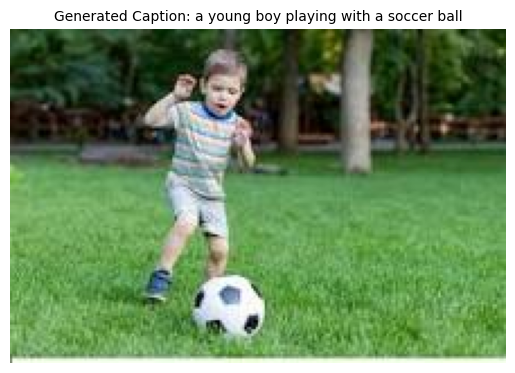

In [ ]:
from transformers import AutoTokenizer, AutoModelForVision2Seq, AutoImageProcessor
from PIL import Image
import torch
import matplotlib.pyplot as plt
import os

# Define the path to the fine-tuned model
model_path = "/content/drive/MyDrive/image caption generator/flickr8k-finetuned-model-final"

# Check if the model path exists
if not os.path.exists(model_path):
    print(f"Error: Model path not found at {model_path}")
else:
    print("Loading fine-tuned model...")
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    finetuned_tokenizer = AutoTokenizer.from_pretrained(model_path)
    finetuned_image_processor = AutoImageProcessor.from_pretrained(model_path)
    finetuned_model = AutoModelForVision2Seq.from_pretrained(model_path)
    finetuned_model = finetuned_model.to(device)

    print("Fine-tuned model loaded successfully!")

    # Define the path to the image you want to caption
    test_image_path = "/content/image.jpeg"

    # Check if the image path exists
    if not os.path.exists(test_image_path):
        print(f"Error: Image not found at {test_image_path}")
    else:
        print(f"\nGenerating caption for image: {test_image_path}")

        # Function to generate caption for a single image
        def generate_caption(image_path, model, image_processor, tokenizer, device):
            """Generate caption for a single image"""
            image = Image.open(image_path).convert('RGB')
            pixel_values = image_processor(image, return_tensors="pt")['pixel_values'].to(device)

            # Generate caption
            with torch.no_grad():
                generated_ids = model.generate(pixel_values, max_length=50, num_beams=4)

            # Decode caption
            caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
            return caption

        # Generate the caption
        caption = generate_caption(test_image_path, finetuned_model, finetuned_image_processor, finetuned_tokenizer, device)
        print(f"Generated caption: {caption}")

        # Display the image with the generated caption
        image = Image.open(test_image_path).convert('RGB')
        plt.imshow(image)
        plt.title(f"Generated Caption: {caption}", fontsize=10, wrap=True)
        plt.axis('off')
        plt.show()

Loading fine-tuned model...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


Fine-tuned model loaded successfully!

Generating caption for image: /content/classroom-image.jpg
Generated caption: a group of children sitting at desks in a classroom


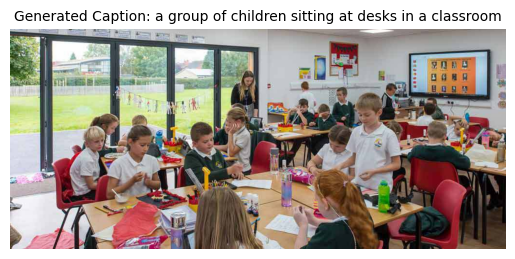

In [ ]:
from transformers import AutoTokenizer, AutoModelForVision2Seq, AutoImageProcessor
from PIL import Image
import torch
import matplotlib.pyplot as plt
import os

# Define the path to the fine-tuned model
model_path = "/content/drive/MyDrive/image caption generator/flickr8k-finetuned-model-final"

# Check if the model path exists
if not os.path.exists(model_path):
    print(f"Error: Model path not found at {model_path}")
else:
    print("Loading fine-tuned model...")
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    finetuned_tokenizer = AutoTokenizer.from_pretrained(model_path)
    finetuned_image_processor = AutoImageProcessor.from_pretrained(model_path)
    finetuned_model = AutoModelForVision2Seq.from_pretrained(model_path)
    finetuned_model = finetuned_model.to(device)

    print("Fine-tuned model loaded successfully!")

    # Define the path to the image you want to caption
    test_image_path = "/content/classroom-image.jpg"

    # Check if the image path exists
    if not os.path.exists(test_image_path):
        print(f"Error: Image not found at {test_image_path}")
    else:
        print(f"\nGenerating caption for image: {test_image_path}")

        # Function to generate caption for a single image
        def generate_caption(image_path, model, image_processor, tokenizer, device):
            """Generate caption for a single image"""
            image = Image.open(image_path).convert('RGB')
            pixel_values = image_processor(image, return_tensors="pt")['pixel_values'].to(device)

            # Generate caption
            with torch.no_grad():
                generated_ids = model.generate(pixel_values, max_length=50, num_beams=4)

            # Decode caption
            caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
            return caption

        # Generate the caption
        caption = generate_caption(test_image_path, finetuned_model, finetuned_image_processor, finetuned_tokenizer, device)
        print(f"Generated caption: {caption}")

        # Display the image with the generated caption
        image = Image.open(test_image_path).convert('RGB')
        plt.imshow(image)
        plt.title(f"Generated Caption: {caption}", fontsize=10, wrap=True)
        plt.axis('off')
        plt.show()

In [ ]:
"""
Gradio app to generate image captions using a fine-tuned Vision2Seq model (Hugging Face Transformers).
Save this file as `gradio_image_caption_app.py` and run it with `python gradio_image_caption_app.py`.

Requirements:
    pip install --upgrade transformers gradio pillow torch
(For CUDA-enabled torch, install following PyTorch's instructions for your CUDA version.)

This script loads a model from `model_path` and exposes a simple UI to upload an image and generate a caption.
"""

import os
from pathlib import Path
from typing import Tuple

import gradio as gr
from PIL import Image
import torch
from transformers import AutoTokenizer, AutoModelForVision2Seq, AutoImageProcessor


DEFAULT_MODEL_PATH = "/content/drive/MyDrive/image caption generator/flickr8k-finetuned-model-final"
DEFAULT_MAX_LENGTH = 50
DEFAULT_NUM_BEAMS = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

_model_cache = {}

def load_model(model_path: str):
    """Load tokenizer, image_processor and model from a local path or HF hub path. Cached across calls."""
    model_path = str(model_path)
    if model_path in _model_cache:
        return _model_cache[model_path]

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model path not found: {model_path}")

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    image_processor = AutoImageProcessor.from_pretrained(model_path)
    model = AutoModelForVision2Seq.from_pretrained(model_path)
    model = model.to(DEVICE)
    model.eval()

    _model_cache[model_path] = (tokenizer, image_processor, model)
    return tokenizer, image_processor, model


def generate_caption_from_image(pil_image: Image.Image,
                                model_path: str = DEFAULT_MODEL_PATH,
                                max_length: int = DEFAULT_MAX_LENGTH,
                                num_beams: int = DEFAULT_NUM_BEAMS) -> Tuple[str, Image.Image]:
    """Return (caption, pil_image) for display in the Gradio UI."""
    if pil_image is None:
        return "No image provided", None

    # Ensure correct mode
    if pil_image.mode != "RGB":
        pil_image = pil_image.convert("RGB")

    # load model components
    tokenizer, image_processor, model = load_model(model_path)

    # prepare inputs
    pixel_values = image_processor(pil_image, return_tensors="pt")["pixel_values"].to(DEVICE)

    # generate ids
    with torch.no_grad():
        generated_ids = model.generate(pixel_values,
                                       max_length=max_length,
                                       num_beams=max(1, int(num_beams)),
                                       early_stopping=True,
                                       do_sample=False)

    # decode
    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True).strip()

    return caption, pil_image



def build_ui():
    with gr.Blocks(title="Image Caption Generator (Fine-tuned Vision2Seq)") as demo:
        gr.Markdown("# Image Caption Generator")
        gr.Markdown("Upload an image and the fine-tuned Vision2Seq model will create a caption.")

        with gr.Row():
            with gr.Column(scale=1):
                image_input = gr.Image(type="pil", label="Upload Image", interactive=True)
                model_path_input = gr.Textbox(value=DEFAULT_MODEL_PATH, label="Model path (local or HF repo)")
                max_length_slider = gr.Slider(minimum=10, maximum=150, value=DEFAULT_MAX_LENGTH, step=1, label="Max length")
                num_beams_slider = gr.Slider(minimum=1, maximum=8, value=DEFAULT_NUM_BEAMS, step=1, label="Number of beams")
                generate_button = gr.Button("Generate Caption")
                reload_button = gr.Button("Reload Model")

                status = gr.Textbox(value=f"Device: {DEVICE}. Model loaded from: {DEFAULT_MODEL_PATH}", label="Status", interactive=False)

            with gr.Column(scale=1):
                output_image = gr.Image(type="pil", label="Image")
                caption_output = gr.Textbox(label="Generated caption", interactive=False)


        def _generate(image, model_path, max_length, num_beams):
            try:
                caption, out_img = generate_caption_from_image(image, model_path, int(max_length), int(num_beams))
                status_text = f"OK — generated using model: {model_path} on {DEVICE}"
            except FileNotFoundError as e:
                caption = str(e)
                out_img = image
                status_text = "Error — model path not found"
            except Exception as e:
                caption = f"Error during generation: {e}"
                out_img = image
                status_text = "Error — see message above"
            return out_img, caption, status_text

        def _reload_model(model_path):
            try:
                load_model(model_path)
                return f"Model loaded from: {model_path}"
            except Exception as e:
                return f"Failed to load model: {e}"

        generate_button.click(fn=_generate,
                              inputs=[image_input, model_path_input, max_length_slider, num_beams_slider],
                              outputs=[output_image, caption_output, status])

        reload_button.click(fn=_reload_model, inputs=[model_path_input], outputs=[status])

        gr.Markdown("---")
        gr.Markdown("Tips: \n- If running on Colab, provide the Google Drive path and mount drive first.\n- For large models use a machine with GPU.\n- If your model is on Hugging Face Hub, replace the model path with the repo id (e.g. 'username/repo').")

    return demo



if __name__ == "__main__":
    demo = build_ui()
    demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bfa4a8ae64b20763a8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
